In [107]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from envs.createEnvs import createCSVEnv
from envs.environments import NeuralNetwork
from utilities.offlineModelsAux import process_jsons

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [108]:
#Hyperparameters
verbose = True

shape = "5x5"

algorithms = ["Q-Learning", "DDQN", "Q-Learning"]

if shape == "5x5":
    n_rows, n_cols = 5, 5
    n_epochs = 2000
elif shape == "14x14":
    n_rows, n_cols = 14, 14
    n_epochs = 3000

# Create environment so we can later test the models generated with the function env.test()
env = createCSVEnv(shape)#, render=False)

In [100]:
dicts = process_jsons(algorithms, shape)

if verbose:
    for family in dicts:
        print("Familia", family)
        print("Nº de trayectorias:", dicts[family]["count"])
        #print("Estimación del numero de movimientos por familia:", dicts[family]["length"]/dicts[family]["count"])
        print("Nº de tuplas SAS:", dicts[family]["length"])
        print("Tamaño de sy_values:", len(dicts[family]["sy_values"]))
        print(dicts[family]["sy_values"])
        print(dicts[family]["sx_values"])
        print(dicts[family]["a_values"])
        print(dicts[family]["sy1_values"])
        print(dicts[family]["sx1_values"])
        print("--------------------------------------------------")

Familia (4, 0)
Nº de trayectorias: 127
Nº de tuplas SAS: 1024
Tamaño de sy_values: 1024
[4.0, 3.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 4.0, 3.0, 2.0, 2.0, 2.0, 2.0, 1

In [101]:
#Ahora tengo que generar un tensor input y uno target para cada familia
family_names = []
inputs = []
targets = []
inputs_tensor = []
targets_tensor = []

for family in dicts:
    family_names.append(family)
    sy_array = np.array(dicts[family]["sy_values"])
    sx_array = np.array(dicts[family]["sx_values"])
    a_array = np.array(dicts[family]["a_values"])
    sy1_array = np.array(dicts[family]["sy1_values"])
    sx1_array = np.array(dicts[family]["sx1_values"])

    inputs.append(np.column_stack((sy_array, sx_array, a_array))) 
    targets.append(np.column_stack((sy1_array, sx1_array)))

if verbose:
    for family in family_names:
        print("Familias:", family)
        print("Inputs:", len(inputs[family_names.index(family)]))
        print("Targets:", len(targets[family_names.index(family)]))
        print("--------------------------------------------------")

Familias: (4, 0)
Inputs: 1024
Targets: 1024
--------------------------------------------------
Familias: (2, 0)
Inputs: 954
Targets: 954
--------------------------------------------------
Familias: (0, 0)
Inputs: 1104
Targets: 1104
--------------------------------------------------


In [93]:
models_arr = []
criterion_arr = []
optimizer_arr = []
X_train_arr = []
X_test_arr = []
y_train_arr = []
y_test_arr = []
losses_arr = []

for family in family_names:

    if shape == "5x5":
        model = NeuralNetwork(3, 2)
    elif shape == "14x14":
        model = NeuralNetwork(3, 2, 128, 64)
    print("Entrenando modelo para la familia", family, "del laberinto", shape)

    # Define the loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())

    X_train, X_test, y_train, y_test = train_test_split(inputs[family_names.index(family)], targets[family_names.index(family)], test_size=0.2)
    
    # Convert NumPy arrays to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    losses = []

    for epoch in range(n_epochs):
        # Forward pass
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())

    models_arr.append(model)
    criterion_arr.append(criterion)
    optimizer_arr.append(optimizer)
    X_train_arr.append(X_train_tensor)
    X_test_arr.append(X_test_tensor)
    y_train_arr.append(y_train_tensor)
    y_test_arr.append(y_test_tensor)    
    losses_arr.append(losses)

    print("Modelo entrenado!")

Entrenando modelo para la familia (4, 0) del laberinto 5x5
Modelo entrenado!
Entrenando modelo para la familia (2, 0) del laberinto 5x5
Modelo entrenado!
Entrenando modelo para la familia (0, 0) del laberinto 5x5
Modelo entrenado!


In [94]:
for i in range(len(models_arr)):
    # Evaluate the model on the test data
    with torch.no_grad():
        test_outputs = models_arr[i](X_test_arr[i])
        test_loss = criterion(test_outputs, y_test_arr[i])
        print(f'Test loss: {test_loss.item()}')

Test loss: 0.0003629753482528031
Test loss: 0.00044751365203410387
Test loss: 0.0008145851315930486


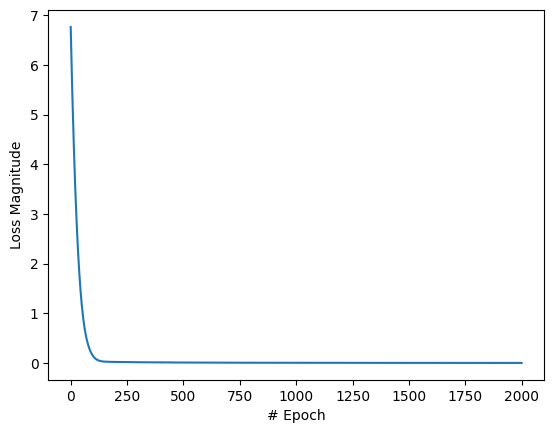

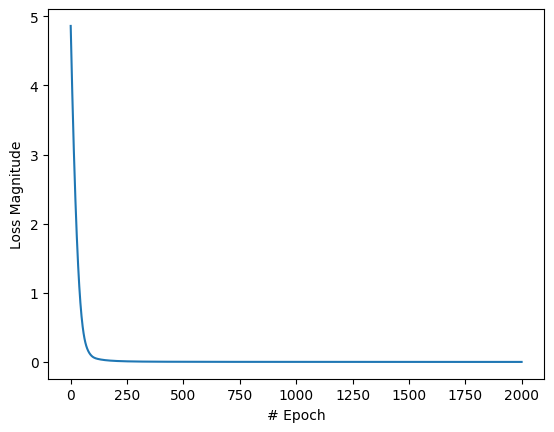

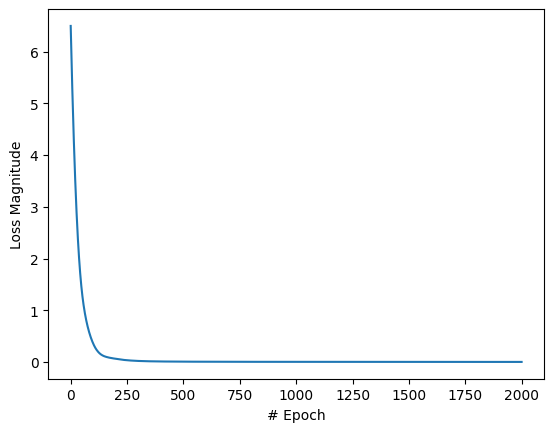

In [95]:
for i in range(len(models_arr)):
    # Plot the training loss
    plt.xlabel("# Epoch")
    plt.ylabel("Loss Magnitude")
    plt.plot(losses_arr[i])
    plt.show()

In [96]:
#Ahora voy a guardar los modelos en un archivo con un nombre que dependa de su familia y del laberinto
for i in range(len(models_arr)):
    torch.save(models_arr[i].state_dict(), '../data/offline_trajectory_models/_modelo_entorno' + shape + '_familia_' + str(family_names[i][0]) + '_' + str(family_names[i][1]) + '.pt')
    print('Modelo guardado en: ../data/offline_trajectory_models/_modelo_entorno' + shape + '_familia_' + str(family_names[i][0]) + '_' + str(family_names[i][1]) + '.pt')

Modelo guardado en: ../data/offline_trajectory_models/_modelo_entorno5x5_familia_4_0.pt
Modelo guardado en: ../data/offline_trajectory_models/_modelo_entorno5x5_familia_2_0.pt
Modelo guardado en: ../data/offline_trajectory_models/_modelo_entorno5x5_familia_0_0.pt


Ahora hay que probar los modelos generados

In [122]:
# Perform predictions
for j in range(n_rows):
    for k in range(n_cols):
        for i in range(4):
            env_result = env.unwrapped.test([j, k, i])

            if not(type(env_result) == str): #if it's a string, it means it's a wall
                test_input = torch.tensor([[float(j), float(k), float(i)]], dtype=torch.float32)
                
                print("Input: " + str([j, k, i]))
                print("Expected output: " + str(env_result))

                for i in range(len(models_arr)):
                    resultado = models_arr[i](test_input)
                    resultado = resultado.detach().numpy()

                    print("Family " + str(family_names[i]) + ":   [" + str(round(resultado[0][0])) + " " + str(round(resultado[0][1])) + "]")
                print("--------------------------------------------------\n")

Input: [0, 0, 0]
Expected output: [0 0]
Family (4, 0):   [0 0]
Family (2, 0):   [0 0]
Family (0, 0):   [1 0]
--------------------------------------------------

Input: [0, 0, 1]
Expected output: [1 0]
Family (4, 0):   [0 0]
Family (2, 0):   [0 1]
Family (0, 0):   [1 0]
--------------------------------------------------

Input: [0, 0, 2]
Expected output: [0 0]
Family (4, 0):   [0 1]
Family (2, 0):   [0 1]
Family (0, 0):   [1 1]
--------------------------------------------------

Input: [0, 0, 3]
Expected output: [0 1]
Family (4, 0):   [0 1]
Family (2, 0):   [1 1]
Family (0, 0):   [0 1]
--------------------------------------------------

Input: [0, 1, 0]
Expected output: [0 1]
Family (4, 0):   [0 1]
Family (2, 0):   [0 1]
Family (0, 0):   [0 1]
--------------------------------------------------

Input: [0, 1, 1]
Expected output: [1 1]
Family (4, 0):   [0 1]
Family (2, 0):   [0 1]
Family (0, 0):   [1 1]
--------------------------------------------------

Input: [0, 1, 2]
Expected output: 

Voy a hacer una simulacion empezando desde 0,0

In [138]:

y, x = 1, 1

for i in range(4):
    posibilidades = []

    test_input = torch.tensor([[float(y), float(x), float(i)]], dtype=torch.float32)
    
    print("Input: " + str([y, x, i]))

    for i in range(len(models_arr)):
        resultado = models_arr[i](test_input)
        resultado = resultado.detach().numpy()
        posibilidades.append([round(resultado[0][0]), round(resultado[0][1])])
    
    print("Estados futuros predichos: " + str(posibilidades))

    #Calculo el porcentaje de veces que aparece cada posibilidad
    probability_dict = {str(posibilidades.count(p)/len(posibilidades)*100) + "%": p for p in posibilidades}

    probability_dict = {}
    for p in posibilidades:
        if not str(p) in probability_dict:
            probability_dict[str(p)] = str(posibilidades.count(p)/len(posibilidades))


    print("Probabilidades: ")
    for p in probability_dict:
        print(p + ": " + probability_dict[p])

    #print("Probabilidad " + str(p) + ": " + str(posibilidades.count(p)/len(posibilidades)*100) + "%")
    
    print("--------------------------------------------------\n")

Input: [1, 1, 0]
Estados futuros predichos: [[0, 1], [0, 1], [1, 1]]
Probabilidades: 
[0, 1]: 0.6666666666666666
[1, 1]: 0.3333333333333333
--------------------------------------------------

Input: [1, 1, 1]
Estados futuros predichos: [[1, 1], [1, 1], [2, 1]]
Probabilidades: 
[1, 1]: 0.6666666666666666
[2, 1]: 0.3333333333333333
--------------------------------------------------

Input: [1, 1, 2]
Estados futuros predichos: [[1, 2], [1, 2], [2, 2]]
Probabilidades: 
[1, 2]: 0.6666666666666666
[2, 2]: 0.3333333333333333
--------------------------------------------------

Input: [1, 1, 3]
Estados futuros predichos: [[1, 2], [1, 2], [1, 2]]
Probabilidades: 
[1, 2]: 1.0
--------------------------------------------------



In [97]:
# Función para combinar modelos individuales en un modelo global
def combine_models(models):
    class CombinedModel(nn.Module):
        def __init__(self, models):
            super(CombinedModel, self).__init__()
            self.models = nn.ModuleList(models)

        def forward(self, x):
            outputs = [model(x) for model in self.models]
            return torch.mean(torch.stack(outputs), dim=0)

    return CombinedModel(models)

# Combina los modelos individuales en un modelo global
global_model = combine_models([model_family1, model_family2, ...])  # Agrega todos los modelos necesarios

NameError: name 'model_family1' is not defined

In [ ]:
# Función para capturar la incertidumbre utilizando Monte Carlo
def capture_uncertainty(model, state, num_samples=100):
    outputs = torch.zeros((num_samples, state.size(0), model.fc.out_features))

    for i in range(num_samples):
        outputs[i, :, :] = model(state)

    uncertainty = torch.var(outputs, dim=0).mean(dim=-1)
    return uncertainty

# Supongamos que tienes un estado 'sample_state' para el cual deseas capturar la incertidumbre
sample_state = torch.Tensor(...)  # Reemplaza ... con tu estado

# Captura la incertidumbre para el estado dado utilizando Monte Carlo
uncertainty = capture_uncertainty(global_model, sample_state)
print("Uncertainty:", uncertainty)